<a href="https://colab.research.google.com/github/ven7sg/DS-3001-project-voting/blob/main/Project3_model%26VIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
! git clone https://github.com/ven7sg/DS-3001-project-voting.git

Cloning into 'DS-3001-project-voting'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 134 (delta 30), reused 42 (delta 17), pack-reused 63
Receiving objects: 100% (134/134), 38.43 MiB | 21.34 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [13]:
#!rm -r DS-3001-project-voting

In [ ]:
!pip3 install mapclassify

In [ ]:
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
gdf = gpd.read_file('/content/drive/My Drive/Colab Notebooks/va_admin_bndry/VirginiaCounty_ClippedToShoreline.shx') # Load Virginia shapefile for maps
cdf = pd.read_csv('/content/DS-3001-project-voting/cleaned data/county_final.csv') # Load county adjacency data and population data
vdf = pd.read_csv('/content/DS-3001-project-voting/cleaned data/voting_final.csv') # Load historical voting data
merged = pd.read_csv('/content/DS-3001-project-voting/cleaned data/merged_final.csv') #merged cdf and vdf

# Merge shapefile data and county adjacency data:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf,left_on='FIPS_left',right_on='county_fips')  # merge county population and adjacency data into df


In [ ]:
nhgis_county_data=gpd.read_file('/content/DS-3001-project-voting/data/0002_ds250_20205_county_M.csv')
nhgis_county_data

In [ ]:
#nhgis county data cleaning (Carol Wu)
virginia_data = nhgis_county_data[nhgis_county_data['STATE'] == 'Virginia']

#remove YEAR STUSAB REGIONA DIVISIONA STATE STATEA (all VA 2016-2020)
for col in virginia_data.columns:
    if len(virginia_data[col].unique()) == 1:
        virginia_data.drop(col,inplace=True,axis=1)
#select nativity, poverty status by sex, gini index of income ineuqality col
VAcounty_data = virginia_data[['COUNTY','AM0KM002','AM0KM003','AM0KM004','AM0KM005','AM0KM006','AM63M003','AM63M017','AM63M032','AM63M046','AM9SM001']]

In [ ]:
column_mapping = {
    'COUNTY' : 'county',
    'AM0KM002': 'U.S. citizen, born in the United States',
    'AM0KM003': 'U.S. citizen, born in Puerto Rico or U.S. Island Areas',
    'AM0KM004': 'U.S. citizen, born abroad of American parent(s)',
    'AM0KM005': 'U.S. citizen by naturalization',
    'AM0KM006': 'Not a U.S. citizen',
    'AM63M003': 'Income in the past 12 months below poverty level: Male',
    'AM63M017': 'Income in the past 12 months below poverty level: Female',
    'AM63M032': 'Income in the past 12 months at or above poverty level: Male',
    'AM63M046':  'Income in the past 12 months at or above poverty level: Female',
    'AM9SM001':   'Gini Index'
}

# Rename the columns
VAcounty_data = VAcounty_data.rename(columns=column_mapping)

In [64]:
VAcounty_data

,county,"U.S. citizen, born in the United States","U.S. citizen, born in Puerto Rico or U.S. Island Areas","U.S. citizen, born abroad of American parent(s)",U.S. citizen by naturalization,Not a U.S. citizen,Income in the past 12 months below poverty level: Male,Income in the past 12 months below poverty level: Female,Income in the past 12 months at or above poverty level: Male,Income in the past 12 months at or above poverty level: Female,Gini Index
2822,Accomack County,541,125,113,295,481,548,477,579,509,0.0194
2823,Albemarle County,936,250,299,626,615,578,713,797,809,0.0150
2824,Alleghany County,121,20,96,45,57,205,305,259,296,0.0287
2825,Amelia County,142,20,122,105,80,263,225,257,267,0.0416
2826,Amherst County,190,68,77,132,93,386,358,389,364,0.0211
...,...,...,...,...,...,...,...,...,...,...,...
2950,Suffolk city,665,198,416,283,387,576,671,566,709,0.0178
2951,Virginia Beach city,1982,741,647,1302,1421,1292,1678,1424,1756,0.0104
2952,Waynesboro city,278,42,175,158,260,412,406,426,514,0.0466
2953,Williamsburg city,333,34,98,183,252,222,236,257,273,0.0633


In [65]:
vdf20 = vdf.loc[ vdf['year']==2020,:] # Only the 2020 data
Dvotes = vdf20.loc[(vdf20['party']=='DEMOCRAT'),:].groupby('county_fips')['candidatevotes'].sum()
Dvotes = Dvotes.rename('dem_votes_2020')
Rvotes = vdf20.loc[(vdf20['party']=='REPUBLICAN'),:].groupby('county_fips')['candidatevotes'].sum()
Rvotes = Rvotes.rename('rep_votes_2020')

Dvotes_index = Dvotes.index
FIP = Dvotes_index.tolist()
print(FIP)
VAcounty_data['county_fips'] = FIP
VAcounty_data = VAcounty_data.merge(Dvotes,left_on='county_fips',right_on='county_fips') #for mapping
VAcounty_data = VAcounty_data.merge(Rvotes,left_on='county_fips',right_on='county_fips') #for mapping
print(VAcounty_data)

[51001, 51003, 51005, 51007, 51009, 51011, 51013, 51015, 51017, 51019, 51021, 51023, 51025, 51027, 51029, 51031, 51033, 51035, 51036, 51037, 51041, 51043, 51045, 51047, 51049, 51051, 51053, 51057, 51059, 51061, 51063, 51065, 51067, 51069, 51071, 51073, 51075, 51077, 51079, 51081, 51083, 51085, 51087, 51089, 51091, 51093, 51095, 51097, 51099, 51101, 51103, 51105, 51107, 51109, 51111, 51113, 51115, 51117, 51119, 51121, 51125, 51127, 51131, 51133, 51135, 51137, 51139, 51141, 51143, 51145, 51147, 51149, 51153, 51155, 51157, 51159, 51161, 51163, 51165, 51167, 51169, 51171, 51173, 51175, 51177, 51179, 51181, 51183, 51185, 51187, 51191, 51193, 51195, 51197, 51199, 51510, 51520, 51530, 51540, 51550, 51570, 51580, 51590, 51595, 51600, 51610, 51620, 51630, 51640, 51650, 51660, 51670, 51678, 51680, 51683, 51685, 51690, 51700, 51710, 51720, 51730, 51735, 51740, 51750, 51760, 51770, 51775, 51790, 51800, 51810, 51820, 51830, 51840]
                  county U.S. citizen, born in the United States  \


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1569: FutureWarning: Passing 'suffixes' which cause duplicate columns {'dem_votes_2020_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Numeric only - Training RMSE: 11688.851784811943 R-squared: 0.8653497223766042
Numeric only - Testing RMSE: 11649.134239328654 R-squared: 0.5730196158883043


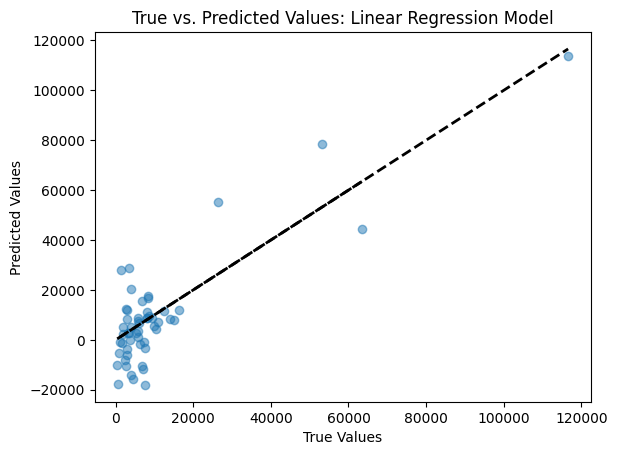

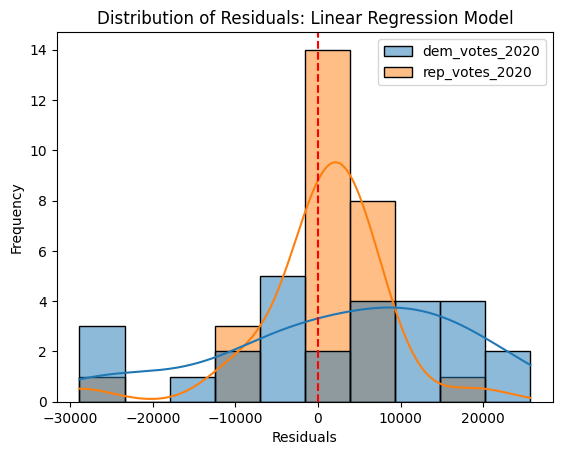

In [77]:
# Numeric variables, Linear Regression, Residuals using Polynomial Features (Carol Wu)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns

#vars = VAcounty_data.columns.tolist()
#print(vars)
numeric_vars = ['U.S. citizen, born in the United States', 'U.S. citizen, born in Puerto Rico or U.S. Island Areas', 'U.S. citizen, born abroad of American parent(s)', 'U.S. citizen by naturalization', 'Not a U.S. citizen', 'Income in the past 12 months below poverty level: Male', 'Income in the past 12 months below poverty level: Female', 'Income in the past 12 months at or above poverty level: Male', 'Income in the past 12 months at or above poverty level: Female', 'Gini Index']

#cast to numeric value
for var in numeric_vars:
    VAcounty_data[var] = pd.to_numeric(VAcounty_data[var], errors='coerce')

# Linear regression model with numeric vars only
X_numeric = VAcounty_data[numeric_vars]
y = VAcounty_data[['dem_votes_2020','rep_votes_2020']]
X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)
linear_reg_numeric = LinearRegression()
linear_reg_numeric.fit(X_train_numeric, y_train)

# Predict on training and test data
y_train_pred_numeric = linear_reg_numeric.predict(X_train_numeric)
y_test_pred_numeric = linear_reg_numeric.predict(X_test_numeric)

# RMSE and R-squared for training and test sets
train_rmse_numeric = np.sqrt(mean_squared_error(y_train, y_train_pred_numeric))
test_rmse_numeric = np.sqrt(mean_squared_error(y_test, y_test_pred_numeric))
train_r2_numeric = r2_score(y_train, y_train_pred_numeric)
test_r2_numeric = r2_score(y_test, y_test_pred_numeric)
print('Numeric only - Training RMSE:', train_rmse_numeric, 'R-squared:', train_r2_numeric)
print('Numeric only - Testing RMSE:', test_rmse_numeric, 'R-squared:', test_r2_numeric)

# Scatter plot for true vs. predicted values
plt.scatter(y_test, y_test_pred_numeric, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values: Linear Regression Model')
plt.show()

# Residuals plot
residuals_poly = y_test - y_test_pred_numeric
sns.histplot(residuals_poly, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals: Linear Regression Model')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()


In [93]:
# Visualize predicted votes in 2024 (Carol Wu)
df = df.merge(Dvotes,left_on='FIPS_left',right_on='county_fips')
df = df.merge(Rvotes,left_on='FIPS_left',right_on='county_fips')

In [92]:
y_pred_numeric = linear_reg_numeric.predict(X_numeric)
y_pred_numeric.shape

(133, 2)

In [94]:

df_pred_votes = pd.DataFrame(y_pred_numeric, columns=['dem_votes_2024', 'rep_votes_2024'])
df = pd.concat([df, df_pred_votes], axis=1)

<Axes: >

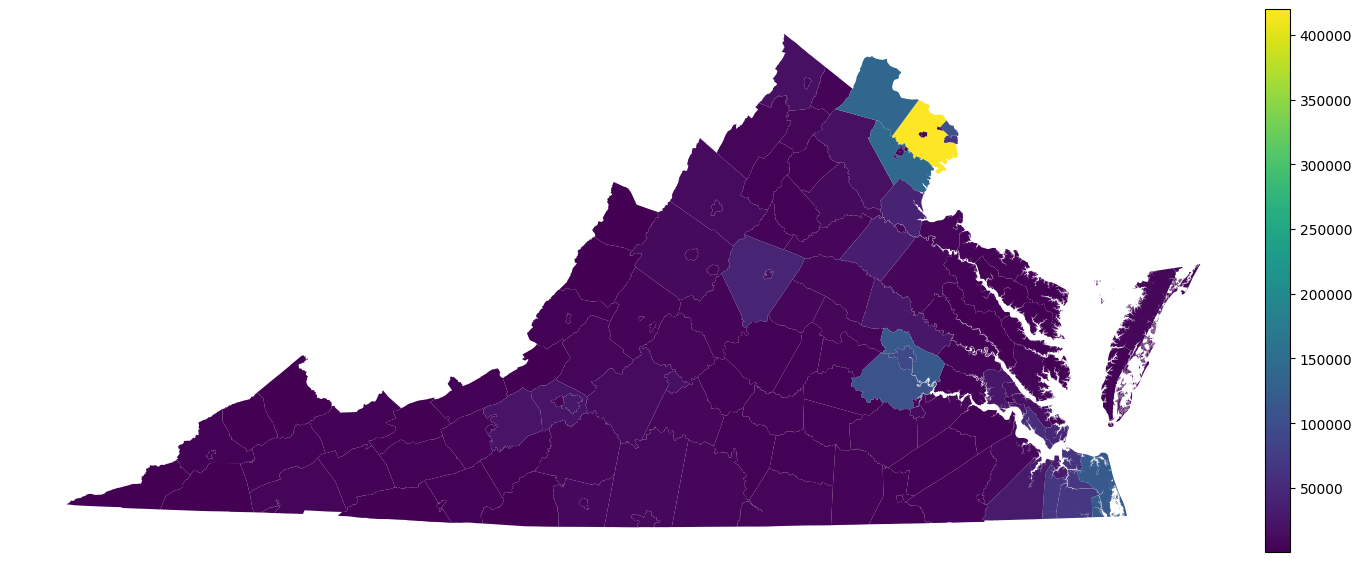

In [96]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='dem_votes_2020',legend=True,cax=cax)

<Axes: >

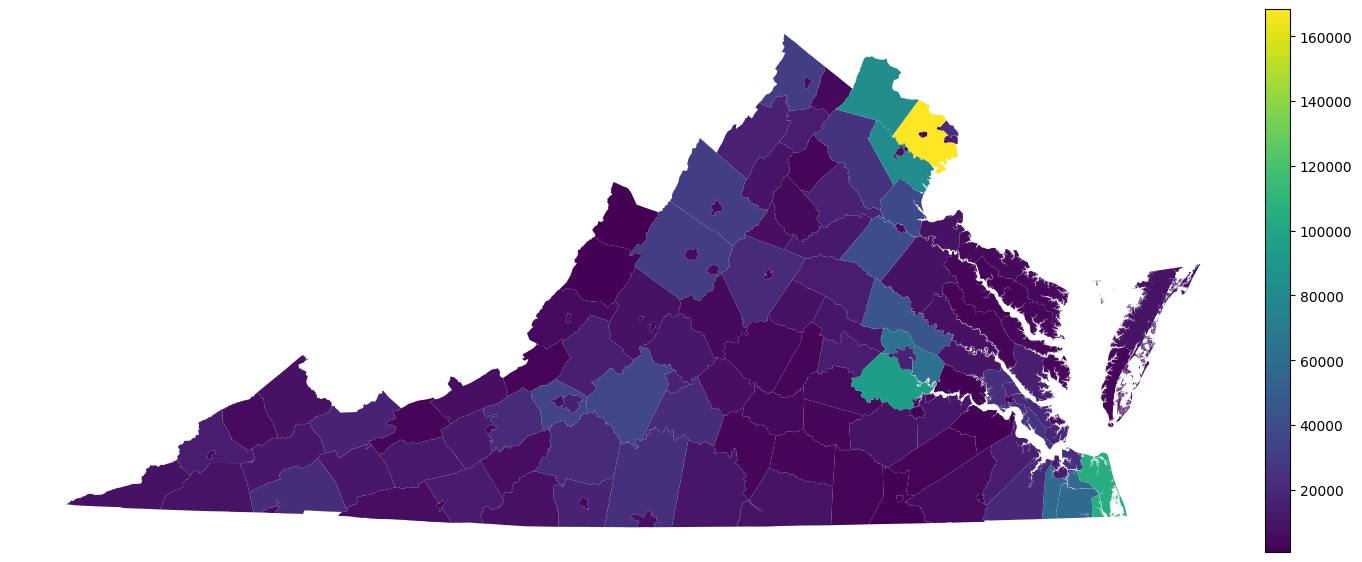

In [98]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='rep_votes_2020',legend=True,cax=cax)

<Axes: >

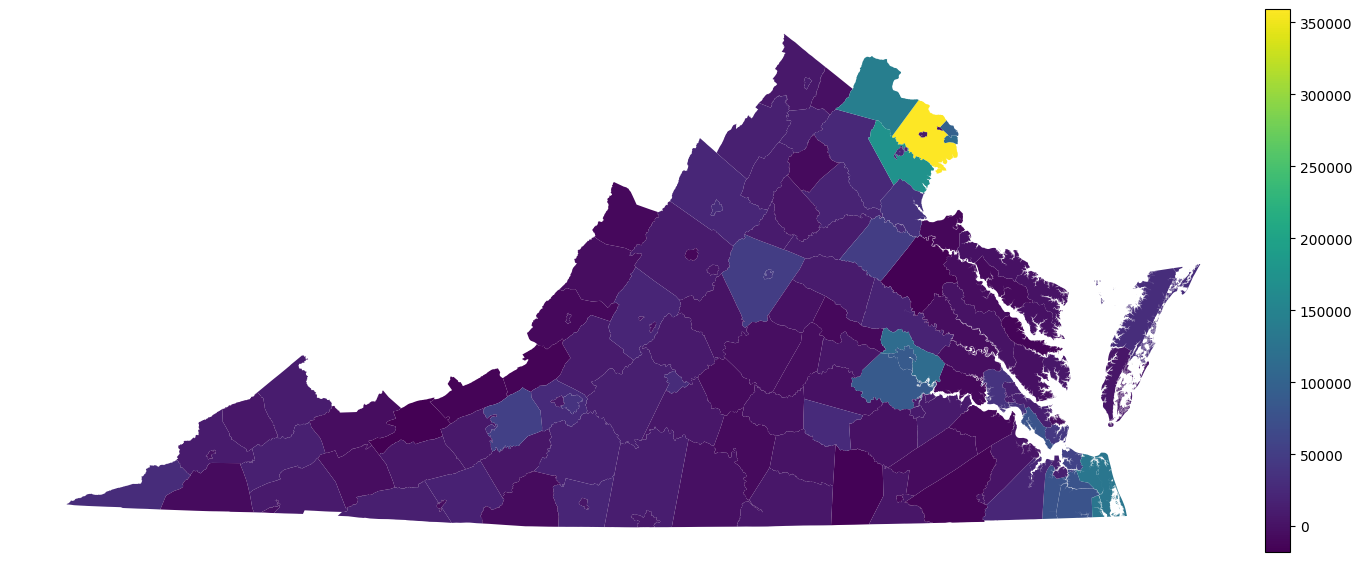

In [97]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='dem_votes_2024',legend=True,cax=cax)

<Axes: >

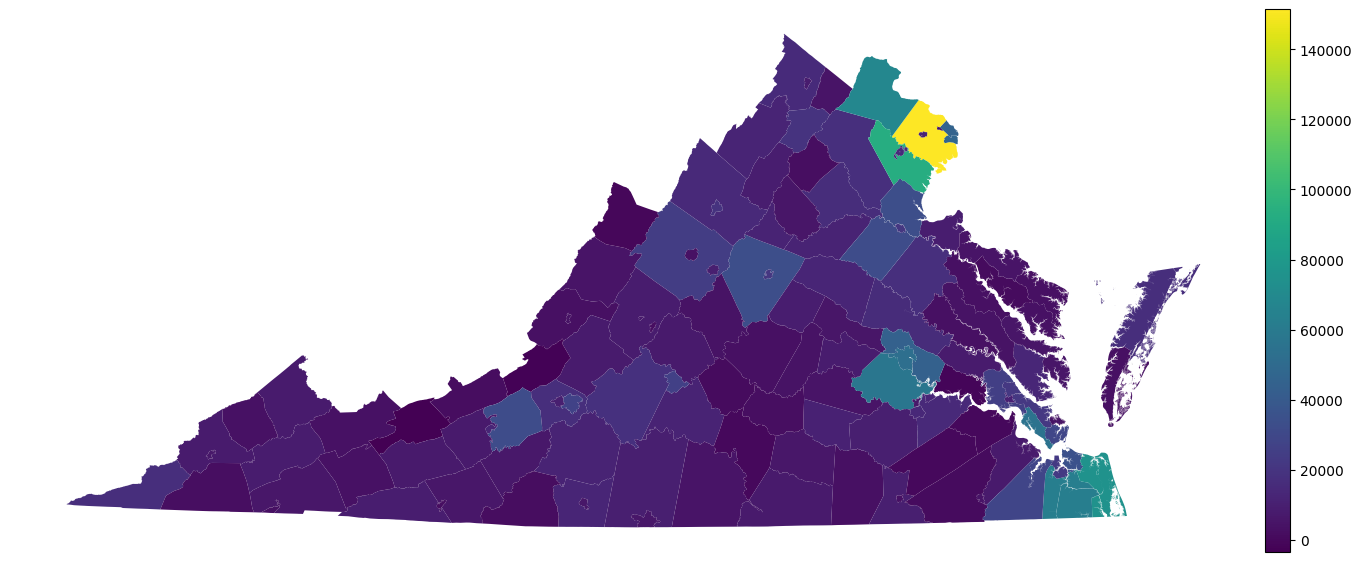

In [99]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='rep_votes_2024',legend=True,cax=cax)